In [1]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import shap
import matplotlib.pyplot as plt

import plotly.express as px


In [2]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
df_balanced = pd.read_csv("../dataset/embled_review_combined.csv", encoding='utf-8')

In [4]:
df_balanced.head(1)

,rating,location_id,review,cleaned_review,embedding,sentiment
0,3,4322585,This was an ornate wat inside Mae Sot. It is a...,ornate wat inside mae sot burmese style wat ty...,[[ 0. 0. 0. ... 0. ...,neutral


In [5]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14067 entries, 0 to 14066
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rating          14067 non-null  int64 
 1   location_id     14067 non-null  int64 
 2   review          14067 non-null  object
 3   cleaned_review  14067 non-null  object
 4   embedding       14067 non-null  object
 5   sentiment       14067 non-null  object
dtypes: int64(2), object(4)
memory usage: 659.5+ KB


In [6]:
df_balanced['length'] = df_balanced['cleaned_review'].apply(lambda x: len(x.split()))

# Calculate statistics
total_reviews = len(df_balanced)
max_length = df_balanced['length'].max()
min_length = df_balanced['length'].min()
avg_length = df_balanced['length'].mean()

# Create a histogram using Plotly
fig = px.histogram(df_balanced, x='length', nbins=20, title='Histogram of Review Lengths')
fig.update_traces(marker_color='rgba(255, 102, 102, 0.7)', marker_line_color='rgba(255, 102, 102, 1)', marker_line_width=1.5)
fig.update_xaxes(title='Number of Words in Review')
fig.update_yaxes(title='Count of Reviews')

# Add a mini box with summary statistics
summary_text = f"""
Total Reviews: {total_reviews}<br>
Max Words: {max_length}<br>
Min Words: {min_length}<br>
Avg Words: {avg_length:.2f}
"""

fig.add_annotation(
    xref='paper', yref='paper',
    x=0.95, y=0.95,
    text=summary_text,
    showarrow=False,
    bordercolor="black",
    borderwidth=1,
    borderpad=10,
    bgcolor="white",
    font=dict(size=12)
)

# Display the plot
fig.show()

In [7]:
df_balanced['embedding'][0]

'[[ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n ...\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [-0.00701559  0.28866604  0.02099591 ... -0.07148592  0.21406499\n  -0.04538575]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]]'

In [8]:
def convert_embedding(embedding):
    # If the embedding is already a numpy array, return it as is
    if isinstance(embedding, np.ndarray):
        return embedding.flatten()  # Flatten if it's a 2D numpy array
    
    # If the embedding is a string, clean and parse it
    if isinstance(embedding, str):
        # Clean up the embedding string: replace newlines and ensure proper spacing
        embedding = embedding.replace("\n", " ").replace("...", "")
        # Remove extra spaces and brackets for easier parsing
        embedding = embedding.replace("[", "").replace("]", "").strip()
        
        try:
            # Split the cleaned string by spaces and convert it to a list of floats
            embedding_list = [float(val) for val in embedding.split()]
            # Convert the list into a numpy array
            embedding_array = np.array(embedding_list)
            
            # Flatten if it's a 2D array (e.g., matrix)
            return embedding_array.flatten()
        
        except ValueError:
            print(f"Error parsing embedding: {embedding}")
            # Return a zero-vector if there's an issue with parsing
            return np.zeros(300)  # Adjust size as needed
    
    # If it's neither a string nor a numpy array, return a default zero vector
    print(f"Unexpected data type: {type(embedding)}")
    return np.zeros(300)  # Adjust size as needed

In [9]:
df_balanced['embedding'] = df_balanced['embedding'].apply(convert_embedding)

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Convert embeddings from a list to a numpy array for easier processing
embeddings = np.vstack(df_balanced['embedding'].values)

# Apply PCA to reduce dimensions before t-SNE (set n_components to 5 or 10)
pca = PCA(n_components=5, random_state=42)
pca_result = pca.fit_transform(embeddings)

# Use t-SNE to further reduce from 5 dimensions to 2 dimensions
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# Add the t-SNE result to the DataFrame for plotting
df_balanced['tsne-2d-one'] = tsne_result[:, 0]
df_balanced['tsne-2d-two'] = tsne_result[:, 1]

# Create a 2D scatter plot using Plotly
fig = px.scatter(df_balanced,
                x='tsne-2d-one',
                y='tsne-2d-two', 
                color='sentiment',
                 title='t-SNE Scatter Plot of Embeddings by Sentiment',
                 labels={'tsne-2d-one': 't-SNE Dimension 1', 'tsne-2d-two': 't-SNE Dimension 2'},
                 color_discrete_map={
                    'positive': 'rgba(204, 153, 255, 0.6)',  # Light purple
                    'neutral': 'rgba(144, 238, 144, 0.6)',   # Blue-green (turquoise)
                    'negative': 'rgba(255, 165, 0, 0.6)'    # Orange
                })

# Show the plot
fig.show()

In [11]:
mean_length = df_balanced['length'].mean()
percentile_90 = np.percentile(df_balanced['length'], 90)

print(f"Mean Length: {mean_length}")
print(f"90th Percentile: {percentile_90}")

# สร้างกราฟ plot โดยใช้ Plotly เพื่อตรวจสอบ Outliers
fig = px.box(df_balanced, y='length', title='Distribution of Text Lengths with Potential Outliers')
fig.update_traces(marker_color='rgba(144, 238, 144, 0.6)',  # Light green with transparency for the points
                  marker_line_color='rgba(34, 139, 34, 0.8)',  # Darker green for point outlines
                  fillcolor='rgba(144, 238, 144, 0.3)',  # Light green fill for the box area
                  line=dict(color='rgba(34, 139, 34, 0.8)'))  # Darker green for box edges

fig.update_yaxes(title='Number of Words in Review')
fig.update_layout(showlegend=False)

# แสดงกราฟ
fig.show()

Mean Length: 39.747351958484394
90th Percentile: 76.0


In [12]:
# Parameters
embedding_size = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 300  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

In [13]:
sentences = [row.split() for row in df_balanced['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=embedding_size, window=5, min_count=1, workers=4) 

In [14]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [15]:
print(f"X {X.shape}")
print(f"X {y.shape}")

X (14067, 300)
X (14067,)


In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [17]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [18]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.3, random_state=42)

# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")

X_train shape: (9846, 300)
y_train shape: (9846,)
X_test shape: (4221, 300)
y_test shape: (4221,)


In [19]:
# Step 6: Build the GRU Model
gru_units = 128
dropout_rate = 0.5
input_shape = X_train_resampled.shape[1:] 

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_size,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(GRU(units=gru_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(GRU(units=gru_units))
model.add(Dropout(dropout_rate))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))   # 3 classes: negative, neutral, positive



/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,472,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,472,700 (17.06 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,472,700 (17.06 MB)

In [21]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

NameError: name 'y_train' is not defined

In [34]:
class_weights_dict = dict(enumerate(class_weights))

In [35]:
class_weights_dict

{0: 4.190602836879433, 1: 2.643736017897092, 2: 0.419618286728806}

In [23]:
# กำหนดการตั้งค่า Early Stopping และ Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/GRU_models_sample.keras', monitor='val_loss', save_best_only=True)  # เปลี่ยนจาก .h5 เป็น .keras

# ฝึกโมเดล
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=None)


Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 70s 918ms/step - accuracy: 0.4969 - loss: 0.9800 - val_accuracy: 0.5973 - val_loss: 0.8365
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 71s 925ms/step - accuracy: 0.6021 - loss: 0.8233 - val_accuracy: 0.6577 - val_loss: 0.7215
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 860ms/step - accuracy: 0.6758 - loss: 0.7159 - val_accuracy: 0.6951 - val_loss: 0.6688
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 65s 840ms/step - accuracy: 0.7093 - loss: 0.6565 - val_accuracy: 0.7368 - val_loss: 0.6024
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 859ms/step - accuracy: 0.7681 - loss: 0.5412 - val_accuracy: 0.8081 - val_loss: 0.4618
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 854ms/step - accuracy: 0.8239 - loss: 0.4189 - val_accuracy: 0.8266 - val_loss: 0.4244
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 836ms/step - accuracy: 0.8644 - loss: 0.3444 - val_accuracy: 0.8408 - val_loss: 0.3792
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 62s 810ms/step - accuracy: 0.8807 - loss: 0.2944 - val_accu

In [46]:
# 1. Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# 2. Make Predictions
y_pred_prob = model.predict(X_val)

# If your output layer is using 'softmax', y_pred_prob will be probabilities for each class.
# To get the predicted class labels, you can use np.argmax:
y_pred_class = np.argmax(y_pred_prob, axis=1)

# 3. Compare the predicted labels with the true labels
# print(f'Predicted classes: {y_pred_class[:20]}')  # Display the first 10 predictions
# print(f'True classes: {y_val[:20]}')  

132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.9766 - loss: 0.1176
Test Loss: 0.1286
Test Accuracy: 0.9728
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step


In [45]:
conf_matrix = confusion_matrix(y_val, y_pred_class)

print("Accuracy:", accuracy_score(y_val, y_pred_class))
print(classification_report(y_val, y_pred_class))
print(conf_matrix)

Accuracy: 0.9661217720919213
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1453
           1       0.94      0.97      0.95      1374
           2       0.96      0.93      0.95      1394

    accuracy                           0.97      4221
   macro avg       0.97      0.97      0.97      4221
weighted avg       0.97      0.97      0.97      4221

[[1447    0    6]
 [   0 1330   44]
 [  11   82 1301]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred_class, average='weighted')
recall = recall_score(y_val, y_pred_class, average='weighted')
f1 = f1_score(y_val, y_pred_class, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

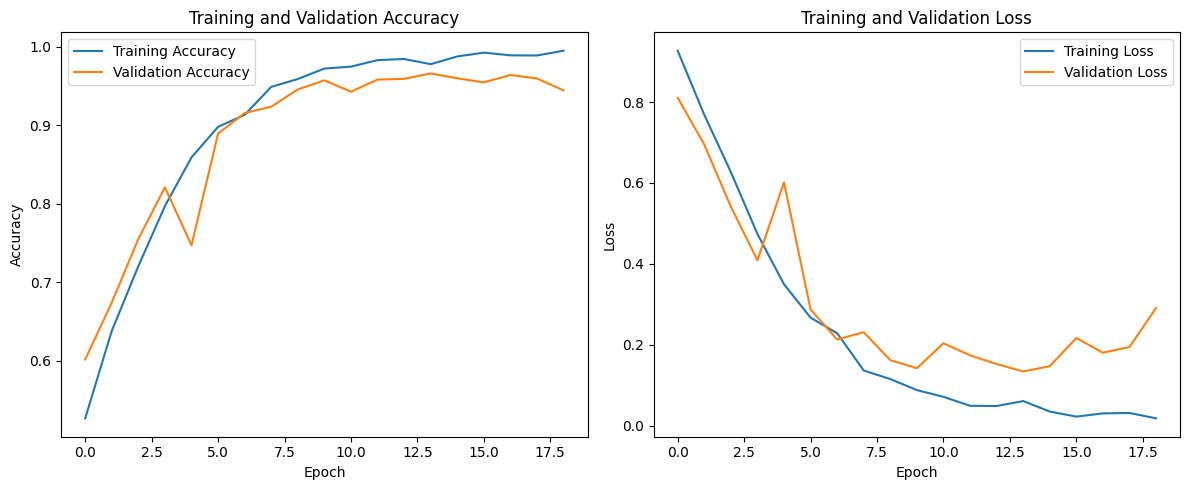

In [40]:
acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [153]:


# predictions_df = pd.DataFrame(data=y_pred_class, index=y_test.index, columns=['predicted_sentiment'])

# review_df.loc[y_test.index, 'predicted_sentiment'] = predictions_df['predicted_sentiment']


In [161]:

predictions_df = pd.DataFrame({
    'review_text': review_df.loc[y_test.index, 'review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': y_test,  # The actual sentiment labels
    'predicted_sentiment': y_pred_class  # The predicted sentiment labels
})

predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.head(5)


,review_text,actual_sentiment,predicted_sentiment
3489,While I should probably come back at a better ...,negative,positive
4909,Nice place Have Food Court KFC Lawson Bic C Se...,positive,positive
1425,Since I was born and grew up in Ceylon (Sri La...,positive,positive
4743,This shrine is located in front of Central\nWo...,neutral,positive
439,Wat Suan Dok is just east of the Old City on S...,positive,positive


In [41]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_class)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9661


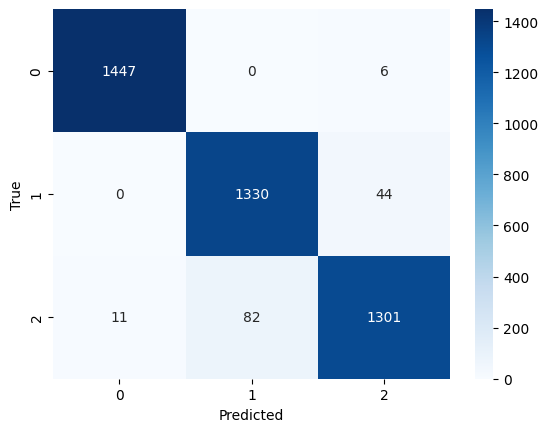

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [137]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_class, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        91
     neutral       0.00      0.00      0.00       157
    positive       0.79      1.00      0.88       934

    accuracy                           0.79      1182
   macro avg       0.26      0.33      0.29      1182
weighted avg       0.62      0.79      0.70      1182



/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume y_test contains true class labels, and y_pred_prob contains predicted probabilities

# Binarize the output labels for calculating AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2

# Calculate the AUC for each class
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average='micro', multi_class='ovr')

print(f'Macro-Averaged AUC: {auc_macro:.4f}')
print(f'Micro-Averaged AUC: {auc_micro:.4f}')

Macro-Averaged AUC: 0.5000
Micro-Averaged AUC: 0.8566


In [165]:
from sklearn.metrics import log_loss

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 0.7264


In [166]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_class)
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: 0.0000
